In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from scipy import stats
from sklearn import cluster
from vincenty import vincenty
from h3 import h3
from folium import Map, Marker, GeoJson
from folium.plugins import MarkerCluster
import folium
import branca.colormap as cm
from geojson.feature import *
import json
from IPython.display import Image, display
import calendar
from tqdm import tqdm


In [2]:
def counts_by_hexagon(df, resolution):
    """
    Use h3.geo_to_h3 to index each data point into the spatial index of the specified resolution.
    Use h3.h3_to_geo_boundary to obtain the geometries of these hexagons
    
    Ex counts_by_hexagon(data, 9)
    """
    df = df[["lat","lng"]]
    
    df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["lat"], row["lng"], resolution), axis = 1)
    
    df_aggreg = df.groupby(by = "hex_id").size().reset_index()
    df_aggreg.columns = ["hex_id", "value"]
    df_aggreg.columns
    
    df_aggreg["geometry"] =  df_aggreg.hex_id.apply(lambda x: 
                                                           {    "type" : "Polygon",
                                                                 "coordinates": 
                                                                [h3.h3_to_geo_boundary(x,geo_json=True)]
                                                            }
                                                        )
    return df_aggreg

def hexagons_dataframe_to_geojson(df_hex, file_output = None):
    """
    Produce the GeoJSON for a dataframe that has a geometry column in geojson 
    format already, along with the columns hex_id and value
    
    Ex counts_by_hexagon(data)
    """    
    list_features = []
    
    for i,row in df_hex.iterrows():
        feature = Feature(geometry = row["geometry"] , id=row["hex_id"], properties = {"value" : row["value"]})
        list_features.append(feature)
        
    feat_collection = FeatureCollection(list_features)
    
    geojson_result = json.dumps(feat_collection)
    
    #optionally write to file
    if file_output is not None:
        with open(file_output,"w") as f:
            json.dump(feat_collection,f)
    
    return geojson_result


def choropleth_map(df_aggreg, border_color = 'black', fill_opacity = 0.7, initial_map = None, with_legend = False,
                   kind = "linear"):
    
    """
    Creates choropleth maps given the aggregated data.
    """    
    #colormap
    min_value = df_aggreg["value"].min()
    max_value = df_aggreg["value"].max()
    m = round ((min_value + max_value ) / 2 , 0)
    
    #take resolution from the first row
    res = h3.h3_get_resolution(df_aggreg.loc[0,'hex_id'])
    
    if initial_map is None:
        initial_map = Map(location= [-40.718728, -73.943802], zoom_start=6, tiles="cartodbpositron", 
                attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
            )
        

    #the colormap 
    #color names accepted https://github.com/python-visualization/branca/blob/master/branca/_cnames.json
    if kind == "linear":
        custom_cm = cm.LinearColormap(['green','yellow','red'], vmin=min_value, vmax=max_value)
    elif kind == "outlier":
        #for outliers, values would be -11,0,1
        custom_cm = cm.LinearColormap(['blue','white','red'], vmin=min_value, vmax=max_value)
    elif kind == "filled_nulls":
        custom_cm = cm.LinearColormap(['sienna','green','yellow','red'], 
                                      index=[0,min_value,m,max_value],vmin=min_value,vmax=max_value)
   

    #create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(df_hex = df_aggreg)
    
    #plot on map
    name_layer = "Choropleth " + str(res)
    if kind != "linear":
        name_layer = name_layer + kind
        
    GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': custom_cm(feature['properties']['value']),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity 
        }, 
        name = name_layer
    ).add_to(initial_map)
    #add legend (not recommended if multiple layers)
    if with_legend == True:
        custom_cm.add_to(initial_map)
    
    
    
    return initial_map

def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis'):
    """
    Scatter plot function for h3 indexed objects
    """    
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])

In [3]:
%time

df_list = [] # list to hold the batch dataframe

TRAIN_PATH = 'phtguber.csv'
# Peep at the training file header
df_tmp = pd.read_csv(TRAIN_PATH, nrows=5)
print(df_tmp.head())

df_tmp.info()

# Set columns to most suitable type to optimize for memory usage
#traintypes = {'tpep_pickup_datetime': 'str', 
#              'PULocationID': 'float16',
#              'DOLocationID': 'float16'}


traintypes = {
              'tpep_pickup_datetime': 'str', 
              'pickup_latitude': 'float32',
              'pickup_longitude': 'float32'}
cols = traintypes.keys()

#cols = list(traintypes.keys())
chunksize = 1_000_000 # 5 million rows at one go. Or try 10 million

for df_chunk in tqdm(pd.read_csv(TRAIN_PATH,  dtype=traintypes, chunksize=chunksize, usecols=cols, sep=';')):#, parse_dates=[0,1])): #usecols=cols,
     
    df_list.append(df_chunk)

1it [00:00, 186.32it/s]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs
  pickup_latitude;pickup_longitude;tpep_pickup_datetime
0  -0.1105803;-78.42409880000002;Pedro luis CHÓEZ...   
1  -0.1427753;-78.4764715;Gabriel eduardo SANDOVA...   
2               -0.1444744;-78.4723421;Gandhy YEROVI   
3  -0.1715153;-78.493752;Andrea verónica PUENTE A...   
4  -0.1761697;-78.4774203;David sebastián ONTANED...   
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 1 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   pickup_latitude;pickup_longitude;tpep_pickup_datetime  5 non-null      object
dtypes: object(1)
memory usage: 168.0+ bytes


In [4]:
traintypes.keys()

dict_keys(['tpep_pickup_datetime', 'pickup_latitude', 'pickup_longitude'])

In [5]:
%time

# Merge all dataframes into one dataframe
train_df = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

# See what we have loaded
train_df.info()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pickup_latitude       1960 non-null   float32
 1   pickup_longitude      1960 non-null   float32
 2   tpep_pickup_datetime  1960 non-null   object 
dtypes: float32(2), object(1)
memory usage: 30.8+ KB


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pickup_latitude       1960 non-null   float32
 1   pickup_longitude      1960 non-null   float32
 2   tpep_pickup_datetime  1960 non-null   object 
dtypes: float32(2), object(1)
memory usage: 30.8+ KB


In [7]:
train_df.describe()

pickup_latitude  pickup_longitude
count      1960.000000       1960.000000
mean         -9.058640        -36.280731
std          21.214001         77.393150
min         -45.898487       -117.038246
25%         -23.987387        -81.860792
50%         -16.526556        -51.144625
75%          13.688845        -43.185564
max          39.919743        176.896713

In [8]:
tripsDB = train_df
tripsDB.head()

pickup_latitude  pickup_longitude              tpep_pickup_datetime
0        -0.110580        -78.424095           Pedro luis CHÓEZ SANTOS
1        -0.142775        -78.476471  Gabriel eduardo SANDOVAL HERRERA
2        -0.144474        -78.472343                     Gandhy YEROVI
3        -0.171515        -78.493752     Andrea verónica PUENTE ACOSTA
4        -0.176170        -78.477417  David sebastián ONTANEDA ANDRADE

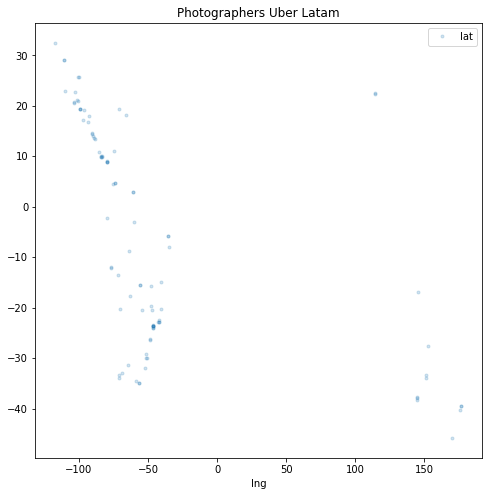

In [9]:
# Keep only location data
dfgeo = tripsDB[['tpep_pickup_datetime','pickup_latitude','pickup_longitude']]

# Simplify column names
dfgeo.columns = ['dt','lat','lng']
test = dfgeo.sample(frac=0.05, replace=False, random_state=1)
test.plot(x='lng',y='lat',style='.',alpha=0.2,figsize=(8,8));
plt.title('Photographers Uber Latam');

In [10]:
dfgeo.describe()

lat          lng
count  1960.000000  1960.000000
mean     -9.058640   -36.280731
std      21.214001    77.393150
min     -45.898487  -117.038246
25%     -23.987387   -81.860792
50%     -16.526556   -51.144625
75%      13.688845   -43.185564
max      39.919743   176.896713

In [11]:
#test = test[dfgeo.lat>-40.4]
#test = test[test.lat<100]
#test.plot(x='lng',y='lat',style='.',alpha=0.2,figsize=(8,8));
#plt.title('Taxi Pickup Locations');

In [12]:
test.head()

dt        lat         lng
991   Rubén alejandro PÉREZ PANDOLFI -33.979164  -70.711975
1602         Eubert BOTELHO DE SOUZA   2.823510  -60.675835
1027            Abraham TORRES CARRO -34.892170  -56.161381
767                 Branka NEDIMOVIC -27.530033  152.949463
1693                 Enrique ALCARAZ  21.165047 -101.677872

In [13]:

#dfgeo = dfgeo.reindex(dfgeo.columns.tolist() + ['geometry.coordinates'], axis=1)
#dfgeo['lng'] = dfgeo['lng'].astype('int')
#dfgeo['lat'] = dfgeo['lat'].astype('int')
#dfgeo['lng'] = dfgeo['geometry.coordinates'].apply(lambda x: x[0]) 
#dfgeo['lat'] = dfgeo['geometry.coordinates'].apply(lambda x: x[1])
#dfgeo['geometry.coordinates'] = dfgeo['lat'].astype(str) + ',' +  dfgeo['lng'].astype(str)
#dfgeo.set_index('geometry.coordinates')
#dfgeo['geometry.coordinates'] = dfgeo['geometry.coordinates'].astype('int')
dfgeo.describe()

lat          lng
count  1960.000000  1960.000000
mean     -9.058640   -36.280731
std      21.214001    77.393150
min     -45.898487  -117.038246
25%     -23.987387   -81.860792
50%     -16.526556   -51.144625
75%      13.688845   -43.185564
max      39.919743   176.896713

In [14]:
dfgeo.head()

dt       lat        lng
0           Pedro luis CHÓEZ SANTOS -0.110580 -78.424095
1  Gabriel eduardo SANDOVAL HERRERA -0.142775 -78.476471
2                     Gandhy YEROVI -0.144474 -78.472343
3     Andrea verónica PUENTE ACOSTA -0.171515 -78.493752
4  David sebastián ONTANEDA ANDRADE -0.176170 -78.477417

In [15]:
df_aggreg = counts_by_hexagon(df = dfgeo, resolution = 8)
df_aggreg.sort_values(by = "value", ascending = False, inplace = True)
hexmap = choropleth_map(df_aggreg = df_aggreg, with_legend = True)
hexmap

In [16]:
df_aggreg.geometry.head(5)
df_aggreg.to_csv('file_name.csv')

In [17]:
df_aggreg_9 = counts_by_hexagon(df = dfgeo, resolution = 9)
df_aggreg_8 = counts_by_hexagon(df = dfgeo, resolution = 8)
df_aggreg_7 = counts_by_hexagon(df = dfgeo, resolution = 7)
df_aggreg_6 = counts_by_hexagon(df = dfgeo, resolution =6)
df_aggreg_5 = counts_by_hexagon(df = dfgeo, resolution =5)
df_aggreg_4 = counts_by_hexagon(df = dfgeo, resolution =4)
df_aggreg_3 = counts_by_hexagon(df = dfgeo, resolution =3)
df_aggreg_2 = counts_by_hexagon(df = dfgeo, resolution =2)



hexmap9 = choropleth_map(df_aggreg = df_aggreg_9,with_legend = False)
hexmap8 = choropleth_map(df_aggreg = df_aggreg_8, initial_map = hexmap9, with_legend = False)
hexmap7 = choropleth_map(df_aggreg = df_aggreg_7, initial_map = hexmap8 , with_legend = False)
hexmap6 = choropleth_map(df_aggreg = df_aggreg_6, initial_map = hexmap7, with_legend = False)
hexmap5 = choropleth_map(df_aggreg = df_aggreg_5, initial_map = hexmap6, with_legend = False)
hexmap4 = choropleth_map(df_aggreg = df_aggreg_4, initial_map = hexmap5, with_legend = False)
hexmap3 = choropleth_map(df_aggreg = df_aggreg_3, initial_map = hexmap4, with_legend = False)
hexmap2 = choropleth_map(df_aggreg = df_aggreg_2, initial_map = hexmap3, with_legend = True)

folium.map.LayerControl('topleft', collapsed=False).add_to(hexmap2)

hexmap2

In [18]:
def basic_local_outliers(df):
    
    '''For each hexagon, compute its value deviation from the mean of its neighbors on its k-rings for k=2 
    (only neighbors with non-null value). 
    Decision rule: local outlier if its value deviates with more than 2 stddev from the mean of the first ring 
            or its value deviates with more than 2 stddev from the mean of the 1st and 2nd k-rings together'''
        
    #create dictionary where key is hex_id and value is number of stops in that hexagon
    dict_hex_value = dict(zip(df_aggreg["hex_id"],df_aggreg["value"]))
    df["is_isolated"] = 0
    df["is_outlier"] = 0
    df["avg_ring_1"] = None
    df["avg_rings_1_2"] = None
    df["stddev_ring_1"] = None
    df["stddev_rings_1_2"] = None
    
    for i,row in df.iterrows():
        
        is_decided = False
        
        current_hex_value = row["value"]
        list_hex_on_rings_levels = h3.k_ring_distances(row["hex_id"], 2)
        
        #on ring 0 it's the current hexagon under analysis
        #on ring 1 
        ring_1 = list(list_hex_on_rings_levels[1])
        values_ring_1 = [dict_hex_value[x] for x in ring_1  if x in dict_hex_value.keys()] 
        
        if len(values_ring_1) >= 1:
            # mean requires at least one data point
            avg_ring_1 = statistics.mean(values_ring_1)
            df.loc[i,'avg_ring_1'] = avg_ring_1 
        
            if len(values_ring_1) >= 2:
                #variance requires at least two data points
                stddev_ring_1 = statistics.stdev(values_ring_1)
                df.loc[i,'stddev_ring_1'] = stddev_ring_1 
                
                if current_hex_value > avg_ring_1 + 2* stddev_ring_1:
                    df.loc[i,'is_outlier'] = 1
                    is_decided = True
                elif current_hex_value < avg_ring_1 - 2* stddev_ring_1:
                    df.loc[i,'is_outlier'] = -1
                    is_decided = True
                    
                
            else:
                #only one hexagone with value on ring 1
                #postpone decision to after computing the second ring
                None
        else:
            #no hexagon with value on ring 1, consider the current one as isolated
            df.loc[i,'is_isolated'] = 1
            is_decided = True
                
            
        if is_decided == False:
            #check also the second ring
            ring_2 = list(list_hex_on_rings_levels[2])
            values_ring_2 = [dict_hex_value[x] for x in ring_2  if x in dict_hex_value.keys()] 
            #consider both rings together
            values_ring_2.extend(values_ring_1)
            avg_rings_1_2 = statistics.mean(values_ring_2)
            df.loc[i,'avg_rings_1_2'] = avg_rings_1_2 
            
            if len(values_ring_2) >= 2:
                stddev_rings_1_2 = statistics.stdev(values_ring_2)
                df.loc[i,'stddev_rings_1_2'] = stddev_rings_1_2 

                if current_hex_value > avg_rings_1_2 + 3* stddev_rings_1_2:
                    df.loc[i,'is_outlier'] = 1
                    is_decided = True
                elif current_hex_value < avg_rings_1_2 - 3* stddev_rings_1_2:
                    df.loc[i,'is_outlier'] = -1
                    is_decided = True 
                
                
            else:
                #it has only 1 hexagon with value within the first 2 k-rings, we consider it isolated
                df.loc[i,'is_isolated'] = 1
                is_decided = True
                
        
                
    return df

In [19]:
import statistics
df_outliers = basic_local_outliers(df = df_aggreg)
df_outliers.head(10)

hex_id  value  \
551   886d741727fffff      7   
469   886d286019fffff      6   
913   88a8100c51fffff      5   
101   884836736bfffff      4   
65    8848086937fffff      4   
52    8845204e33fffff      4   
1645  88be8d12adfffff      4   
249   884995ba31fffff      4   
486   886d2954c5fffff      4   
1593  88be635637fffff      4   

                                               geometry  is_isolated  \
551   {'type': 'Polygon', 'coordinates': [((-89.5679...            1   
469   {'type': 'Polygon', 'coordinates': [((-91.5214...            1   
913   {'type': 'Polygon', 'coordinates': [((-46.6498...            0   
101   {'type': 'Polygon', 'coordinates': [((-104.894...            1   
65    {'type': 'Polygon', 'coordinates': [((-109.931...            1   
52    {'type': 'Polygon', 'coordinates': [((-87.9946...            1   
1645  {'type': 'Polygon', 'coordinates': [((153.0284...            0   
249   {'type': 'Polygon', 'coordinates': [((-99.1681...            0   
486   {'type': 'Polygon', 'coordinates': [((-90.7332...            1   
1593  {'type': 'Polygon', 'coordinates': [((144.9650...            0   

      is_outlier avg_ring_1 avg_rings_1_2 stddev_ring_1 stddev_rings_1_2  
551            0       None          None          None             None  
469            0       None          None          None             None  
913            1          1          None             0             None  
101            0          1             1          None             None  
65             0       None          None          None             None  
52             0       None          None          None             None  
1645           1          1          None             0             None  
249            1          1             1          None                0  
486            0       None          None          None             None  
1593           1        1.5          None      0.707107             None

In [20]:
n_outliers = df_outliers[abs(df_outliers["is_outlier"]) == 1].shape[0]
n_isolated = df_outliers[df_outliers["is_isolated"] == 1].shape[0]

print("out of total:", df_aggreg.shape[0], " hexagons with value, isolated are considered to be:", n_isolated, ", while local outliers identified:",n_outliers)
if n_outliers > 0:
    n_outliers_hot = df_outliers[df_outliers["is_outlier"] == 1].shape[0]
    n_outliers_cold = df_outliers[df_outliers["is_outlier"] == -1].shape[0]

    print("types of local outliers: ", n_outliers_hot, " hot", n_outliers_cold, " cold")

out of total: 1740  hexagons with value, isolated are considered to be: 1299 , while local outliers identified: 64
types of local outliers:  60  hot 4  cold


In [21]:
df_outliers_map = df_outliers[["hex_id","geometry","is_outlier"]]
df_outliers_map.rename(columns = {"is_outlier":"value"}, inplace = True)

m_hex = choropleth_map(df_aggreg = df_aggreg, initial_map=None, with_legend = False)
m_outliers = choropleth_map(df_aggreg = df_outliers_map,  initial_map=m_hex, with_legend = False, kind = "outlier")
folium.map.LayerControl('topleft', collapsed=False).add_to(m_outliers)

m_outliers

/Users/Karl/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
def full_index(df):
    
    df_result = df[["lat","lng","dt"]]
    for resolution in range(0,16):
        new_col = 'hex_id' + str(resolution)
        df_result[new_col] = df_result.apply(lambda row: h3.geo_to_h3(row["lat"], row["lng"], resolution), 
                                             axis = 1)
        
    return df_result

def counts_by_hexagon(df, resolution):
  
    df = df[["lat","lng"]]
    
    df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["lat"], row["lng"], resolution
                                                    ), axis = 1)
    
    df_aggreg = df.groupby(by = "hex_id").size().reset_index()
    df_aggreg.columns = ["hex_id", "value"]
    df_aggreg.columns
    
    df_aggreg["geometry"] =  df_aggreg.hex_id.apply(lambda x: 
                                                           {    "type" : "Polygon",
                                                                 "coordinates": 
                                                                [h3.h3_to_geo_boundary(x,geo_json=True)]
                                                            }
                                                        )
    return df_aggreg

In [23]:
df_list_1 = [] # list to hold the batch dataframe

TRAIN_PATH_1 = 'paris2.csv'

# Peep at the training file header
df_tmp = pd.read_csv(TRAIN_PATH_1, nrows=5)
print(df_tmp.head())

df_tmp.info()

# Set columns to most suitable type to optimize for memory usage
#traintypes = {'tpep_pickup_datetime': 'str', 
#              'PULocationID': 'float16',
#              'DOLocationID': 'float16'}


traintypes_1 = {
              'tpep_pickup_datetime': 'str', 
              'pickup_latitude': 'float32',
              'pickup_longitude': 'float32'}
cols_1 = traintypes_1.keys()

#cols = list(traintypes.keys())
chunksize = 1_000_000 # 5 million rows at one go. Or try 10 million

for df_chunk in tqdm(pd.read_csv(TRAIN_PATH_1,  dtype=traintypes_1, chunksize=chunksize, usecols=cols_1, sep=';')):#, parse_dates=[0,1])): #usecols=cols,
     
    # Neat trick from https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    # Using parse_dates would be much slower!
    #df_chunk['tpep_pickup_datetime'] = df_chunk['tpep_pickup_datetime'].str.slice(0, 16)
    #df_chunk['tpep_pickup_datetime'] = pd.to_datetime(df_chunk['tpep_pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    
    # Can process each chunk of dataframe here
    # clean_data(), feature_engineer(),fit()
    
    # Alternatively, append the chunk to list and merge all
    df_list_1.append(df_chunk)

1it [00:00, 302.77it/s]

  tpep_pickup_datetime;pickup_latitude;pickup_longitude
0                         16/07/2020 19:25;48.9;2.38   
1                        16/07/2020 19:24;48.87;2.38   
2                         16/07/2020 19:23;43.3;5.38   
3  16/07/2020 17:46;50.089999999999996;4.02000000...   
4           16/07/2020 17:39;49.260000000000005;3.97   
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 1 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   tpep_pickup_datetime;pickup_latitude;pickup_longitude  5 non-null      object
dtypes: object(1)
memory usage: 168.0+ bytes


In [24]:
%time

# Merge all dataframes into one dataframe
train_df_1 = pd.concat(df_list_1)

# Delete the dataframe list to release memory
del df_list_1

# See what we have loaded
train_df_1.info()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tpep_pickup_datetime  500 non-null    object 
 1   pickup_latitude       500 non-null    float32
 2   pickup_longitude      500 non-null    float32
dtypes: float32(2), object(1)
memory usage: 7.9+ KB


In [25]:
tripsDB_1 = train_df_1
tripsDB_1.head()

tpep_pickup_datetime  pickup_latitude  pickup_longitude
0     16/07/2020 19:25        48.900002              2.38
1     16/07/2020 19:24        48.869999              2.38
2     16/07/2020 19:23        43.299999              5.38
3     16/07/2020 17:46        50.090000              4.02
4     16/07/2020 17:39        49.259998              3.97

lat         lng
count  500.000000  500.000000
mean    47.028606    2.158400
std      2.259647    2.593585
min     41.910000   -4.090000
25%     44.864999   -0.122500
50%     47.655001    2.330000
75%     48.869999    3.902500
max     50.730000    8.690000

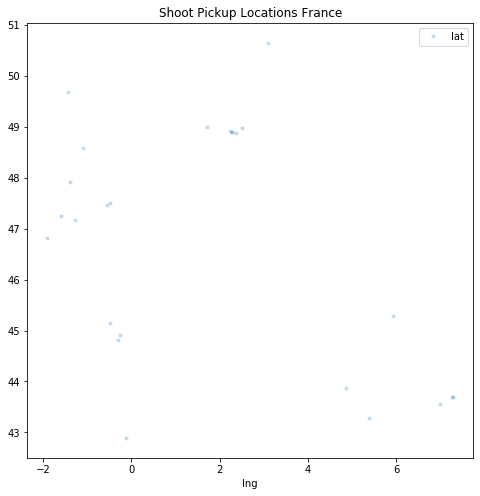

In [26]:
# Keep only location data
dfgeo_1 = tripsDB_1[['tpep_pickup_datetime','pickup_latitude','pickup_longitude']].reset_index(drop=True)

# Simplify column names
dfgeo_1.columns = ['dt','lat','lng']
test_1 = dfgeo_1.sample(frac=0.05, replace=False, random_state=1)
test_1.plot(x='lng',y='lat',style='.',alpha=0.2,figsize=(8,8));
plt.title('Shoot Pickup Locations France');
dfgeo_1.describe()

In [27]:
df_fully_indexed = full_index(dfgeo.head(1000))
df_fully_indexed.head(5)

/Users/Karl/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


lat        lng                                dt          hex_id0  \
0 -0.110580 -78.424095           Pedro luis CHÓEZ SANTOS  8067fffffffffff   
1 -0.142775 -78.476471  Gabriel eduardo SANDOVAL HERRERA  8067fffffffffff   
2 -0.144474 -78.472343                     Gandhy YEROVI  8067fffffffffff   
3 -0.171515 -78.493752     Andrea verónica PUENTE ACOSTA  8067fffffffffff   
4 -0.176170 -78.477417  David sebastián ONTANEDA ANDRADE  8067fffffffffff   

           hex_id1          hex_id2          hex_id3          hex_id4  \
0  8166fffffffffff  8266d7fffffffff  8366d3fffffffff  8466d33ffffffff   
1  8166fffffffffff  8266d7fffffffff  8366d3fffffffff  8466d33ffffffff   
2  8166fffffffffff  8266d7fffffffff  8366d3fffffffff  8466d33ffffffff   
3  8166fffffffffff  8266d7fffffffff  8366d3fffffffff  8466d33ffffffff   
4  8166fffffffffff  8266d7fffffffff  8366d3fffffffff  8466d33ffffffff   

           hex_id5          hex_id6          hex_id7          hex_id8  \
0  8566d333fffffff  8666d3317ffffff  8766d3311ffffff  8866d33119fffff   
1  8566d33bfffffff  8666d33afffffff  8766d33acffffff  8866d33ac7fffff   
2  8566d33bfffffff  8666d33afffffff  8766d33acffffff  8866d33ac7fffff   
3  8566d33bfffffff  8666d33afffffff  8766d33aaffffff  8866d33aa1fffff   
4  8566d33bfffffff  8666d33afffffff  8766d33abffffff  8866d33ab9fffff   

           hex_id9         hex_id10         hex_id11         hex_id12  \
0  8966d331197ffff  8a66d3311957fff  8b66d3311950fff  8c66d33119507ff   
1  8966d33ac73ffff  8a66d33ac707fff  8b66d33ac702fff  8c66d33ac702dff   
2  8966d33ac77ffff  8a66d33ac76ffff  8b66d33ac76efff  8c66d33ac76e1ff   
3  8966d33aa07ffff  8a66d33aa077fff  8b66d33aa075fff  8c66d33aa0753ff   
4  8966d33abd7ffff  8a66d33abd6ffff  8b66d33abd69fff  8c66d33abd69bff   

          hex_id13         hex_id14         hex_id15  
0  8d66d331195077f  8e66d3311950767  8f66d3311950775  
1  8d66d33ac702d3f  8e66d33ac702d07  8f66d33ac702d05  
2  8d66d33ac76e0ff  8e66d33ac76e0c7  8f66d33ac76e0c0  
3  8d66d33aa07537f  8e66d33aa07535f  8f66d33aa07535b  
4  8d66d33ab8b4dbf  8e66d33abd69acf  8f66d33abd69ac9

In [28]:
#set multiindex to the dataframe
list_cols_names = list(df_fully_indexed.columns.values)
list_cols_names_for_index = [x for x in list_cols_names if x[0:6] == 'hex_id' ]


df_fully_indexed_idx = df_fully_indexed.set_index(list_cols_names_for_index, inplace = False)
df_fully_indexed_idx.head(30)

lat  \
hex_id0         hex_id1         hex_id2         hex_id3         hex_id4         hex_id5         hex_id6         hex_id7         hex_id8         hex_id9         hex_id10        hex_id11        hex_id12        hex_id13        hex_id14        hex_id15                     
8067fffffffffff 8166fffffffffff 8266d7fffffffff 8366d3fffffffff 8466d33ffffffff 8566d333fffffff 8666d3317ffffff 8766d3311ffffff 8866d33119fffff 8966d331197ffff 8a66d3311957fff 8b66d3311950fff 8c66d33119507ff 8d66d331195077f 8e66d3311950767 8f66d3311950775  -0.110580   
                                                                                8566d33bfffffff 8666d33afffffff 8766d33acffffff 8866d33ac7fffff 8966d33ac73ffff 8a66d33ac707fff 8b66d33ac702fff 8c66d33ac702dff 8d66d33ac702d3f 8e66d33ac702d07 8f66d33ac702d05  -0.142775   
                                                                                                                                                8966d33ac77ffff 8a66d33ac76ffff 8b66d33ac76efff 8c66d33ac76e1ff 8d66d33ac76e0ff 8e66d33ac76e0c7 8f66d33ac76e0c0  -0.144474   
                                                                                                                8766d33aaffffff 8866d33aa1fffff 8966d33aa07ffff 8a66d33aa077fff 8b66d33aa075fff 8c66d33aa0753ff 8d66d33aa07537f 8e66d33aa07535f 8f66d33aa07535b  -0.171515   
                                                                                                                8766d33abffffff 8866d33ab9fffff 8966d33abd7ffff 8a66d33abd6ffff 8b66d33abd69fff 8c66d33abd69bff 8d66d33ab8b4dbf 8e66d33abd69acf 8f66d33abd69ac9  -0.176170   
                                                                                                                                                8966d33ab83ffff 8a66d33ab81ffff 8b66d33ab819fff 8c66d33ab8195ff 8d66d33ab8194ff 8e66d33ab81948f 8f66d33ab8194f2  -0.178046   
                                                                                                                                8866d33abbfffff 8966d33abb3ffff 8a66d33abb07fff 8b66d33abb00fff 8c66d33abb003ff 8d66d33abb0037f 8e66d33abb00347 8f66d33abb00340  -0.180653   
                                                                                                                                8866d33abdfffff 8966d33abc7ffff 8a66d33abc5ffff 8b66d33abc5bfff 8c66d33abc5b9ff 8d66d33abc5b8bf 8e66d33abc5b8af 8f66d33abc5b8ae  -0.180680   
                                                                                                                                8866d33ab5fffff 8966d33ab53ffff 8a66d33ab52ffff 8b66d33ab52cfff 8c66d33ab52c3ff 8d66d33ab52caff 8e66d33ab52cadf 8f66d33ab52cada  -0.181371   
                                                                                                                                8866d33ab1fffff 8966d33ab03ffff 8a66d33ab037fff 8b66d33ab034fff 8c66d33ab034bff 8d66d33ab034b7f 8e66d33ab034b5f 8f66d33ab034b58  -0.182978   
                                                                                                8666d338fffffff 8766d3388ffffff 8866d33881fffff 8966d33880bffff 8a66d3388017fff 8b66d33880a5fff 8c66d33880a5bff 8d66d33880a5a7f 8e66d33880a5a0f 8f66d33880a5a09  -0.216973   
8081fffffffffff 81807ffffffffff 828047fffffffff 838046fffffffff 8480445ffffffff 85804697fffffff 86804696fffffff 878046969ffffff 888046969bfffff 898046969abffff 8a8046969ab7fff 8b8046969ab6fff 8c8046969ab67ff 8d8046969ab663f 8e8046969ab660f 8f8046969ab660e  -1.362294   
                                                838044fffffffff 8480445ffffffff 8580445bfffffff 868044597ffffff 878044593ffffff 888044593dfffff 898044593c7ffff 8a8044593c4ffff 8b8044593c4cfff 8c8044593c4c5ff 8d8044593c4c43f 8e8044593c4c41f 8f8044593c4c419  -1.413758   
                                                                                                                878044591ffffff 8880445911fffff 898044591c7ffff 8a8044591137fff 8b8044591c69fff 8c8044591c693ff 8d804

In [29]:
def haversine_dist(lon_src, lat_src, lon_dst, lat_dst):
    '''returns distance between GPS points, measured in meters'''

    lon1_rad, lat1_rad, lon2_rad, lat2_rad = map(np.radians, [lon_src, lat_src, lon_dst, lat_dst])

    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0) ** 2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [30]:
def get_knn_busstops(df_h3_indexed, lon_source, lat_source, k, res):
    
    df_neighbors = pd.DataFrame()
    current_ring_number = 0
    
    h3_index_level = "hex_id" + str(res)
    
    #get the hex id for the source
    hex_source = h3.geo_to_h3(lat_source,lon_source,res)  
    
    #if k equals zero return empty dataframe result
    if k == 0:
        return pd.DataFrame(), current_ring_number, pd.DataFrame()
    
    #if k greater than the entire dataset size, return the entire dataset (all distances computed)
    if k > df_h3_indexed.shape[0]:
        df_h3_indexed["distance_to_source"] = df_h3_indexed.loc[:,('longitude','latitude')]\
                                                            .apply(lambda row:
                                                                      haversine_dist(lon_source, lat_source, 
                                                                                     row["longitude"], row["latitude"]), axis =1)
        
        #sort in ascending order of distance to source
        df_h3_indexed.sort_values(by="distance_to_source", ascending = True, inplace = True)
        
        #the number of rings processed corresponds to the distance(in hexagons) between the source's hexagon and the hexagon of the furtherest away point
        furtherest_point_row = df_h3_indexed.tail(1)
        hex_furtherest_point = h3.geo_to_h3(lat=furtherest_point_row["latitude"].values[0],
                                            lng=furtherest_point_row["longitude"].values[0], res=res)
        
        number_rings_processed = h3.h3_distance(hex_source, hex_furtherest_point)
        #if entire dataframe returned, then we don't compute the rings (since we didn't use them anyhow)
        return df_h3_indexed, number_rings_processed, pd.DataFrame()
    
    
    #for k strictly greater than 0 and smaller than the size of entire dataset
    rest_needed =  k - df_neighbors.shape[0]
    
    #hollow rings iteratively used
    while rest_needed > 0:
        
        list_hollow_ring = list(h3.hex_ring(hex_source, current_ring_number))
        
        
        current_candidates = df_h3_indexed.loc[
                                   (df_h3_indexed.index.get_level_values(h3_index_level)).isin(list_hollow_ring )]
        
        print("processing ring:", current_ring_number, ", number of neighbors found before:", df_neighbors.shape[0],", rest_needed:", rest_needed, ", candidates in current iteration:",current_candidates.shape[0])
        
        if current_candidates.shape[0] > 0:
            
            if current_candidates.shape[0]  <= rest_needed:
                #incorporate all as neighbors
                df_neighbors = df_neighbors.append(current_candidates)      
            else:
                #this should be the last iteration, we have more candidates than needed to complete the knn
                current_candidates["distance_to_source"] = current_candidates.loc[:,('lng','lat')]\
                                                            .apply(lambda row:
                                                              haversine_dist(lon_source, lat_source, 
                                                                             row["lng"], row["lat"]), axis =1)
                current_candidates.sort_values(by = "distance_to_source", ascending=True, inplace=True)
                list_sorted_distances = list(current_candidates["distance_to_source"].values)
                
                #it may happen that a point in this ring is closer to source than an already added neighbor from a pprevious ring 
                #we temporary keep all candidates from this ring
                df_neighbors = df_neighbors.append(current_candidates)
                
                

        current_ring_number = current_ring_number + 1
        rest_needed = k - df_neighbors.shape[0]
            
    
            
    #before return, compute distances to source for the rows added from H3 index without computation 
    df_neighbors["distance_to_source"] = df_neighbors.loc[:,('lng','lat','distance_to_source')]\
                                                            .apply(lambda row:
                                                                      haversine_dist(lon_source, lat_source, 
                                                                                     row["lng"], row["lat"])
                                                                      if np.isnan(row["distance_to_source"])
                                                                      else row["distance_to_source"], axis =1)
        
    
    #sort in ascending order of distance to source
    df_neighbors.sort_values(by="distance_to_source", ascending = True, inplace = True)
    
    list_sorted_distances_nh = list(df_neighbors["distance_to_source"].values)
    #print("neighbors distances in ascending order from source:", [round(x,2) for x in list_sorted_distances_nh])
    
    #now do the cut to keep top-k closest to source
    df_neighbors_result = df_neighbors.head(k)
    
    
    #get the list of hexagons in k-ring of processed k
    list_hex_in_rings = list(h3.k_ring(hex_source, current_ring_number))
    df_hex_in_rings = pd.DataFrame({"hex_id": list_hex_in_rings})
    df_hex_in_rings["value"] = 0
    df_hex_in_rings["geometry"] =  df_hex_in_rings.hex_id.apply(lambda x: 
                                                           {    "type" : "Polygon",
                                                                 "coordinates": 
                                                                [h3.h3_to_geo_boundary(x,True)]
                                                            }
                                                        )
    
    
    return df_neighbors_result, current_ring_number, df_hex_in_rings

In [31]:
dfgeo.head(1)
source_point_row = dfgeo.head(1000)
source_point_latitude = source_point_row["lat"].values[3]
source_point_longitude = source_point_row["lng"].values[3]
source_point_name = source_point_row["dt"].values[3]
source_point_latitude, source_point_longitude, source_point_name
len(source_point_row)


1000

In [32]:
source_point_row = dfgeo.head(3)
times = (len(source_point_row))
i = 0
df_knn_array = np.empty(shape=[0, 4])

while i < times:
    source_point_latitude = source_point_row["lat"].values[i]
    print (source_point_latitude)
    source_point_longitude = source_point_row["lng"].values[i]
    source_point_longitude
    res_search = 8
    k_knn = 4
    


    df_knn, n_rings_processed, df_hex_in_rings = get_knn_busstops(df_h3_indexed = df_fully_indexed_idx, 
                                                             lon_source = source_point_longitude, 
                                                             lat_source = source_point_latitude,
                                                             k = k_knn, res = res_search)
    print("===================================================================================================================")    
    print("        To obtain result, we processed " + str(n_rings_processed) + " rings of hexagons (H3 index res=" + str(res_search) + ") around the source point                       ")
    print("===================================================================================================================")
    df_knn
    df_knn_array = np.append(df_knn_array, df_knn)
    i += 1

-0.1105803
processing ring: 0 , number of neighbors found before: 0 , rest_needed: 4 , candidates in current iteration: 1
processing ring: 1 , number of neighbors found before: 1 , rest_needed: 3 , candidates in current iteration: 0
processing ring: 2 , number of neighbors found before: 1 , rest_needed: 3 , candidates in current iteration: 0
processing ring: 3 , number of neighbors found before: 1 , rest_needed: 3 , candidates in current iteration: 0
processing ring: 4 , number of neighbors found before: 1 , rest_needed: 3 , candidates in current iteration: 0
processing ring: 5 , number of neighbors found before: 1 , rest_needed: 3 , candidates in current iteration: 0
processing ring: 6 , number of neighbors found before: 1 , rest_needed: 3 , candidates in current iteration: 0
processing ring: 7 , number of neighbors found before: 1 , rest_needed: 3 , candidates in current iteration: 0
processing ring: 8 , number of neighbors found before: 1 , rest_needed: 3 , candidates in current ite

/Users/Karl/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Karl/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
df_knn

lat  \
hex_id0         hex_id1         hex_id2         hex_id3         hex_id4         hex_id5         hex_id6         hex_id7         hex_id8         hex_id9         hex_id10        hex_id11        hex_id12        hex_id13        hex_id14        hex_id15                    
8067fffffffffff 8166fffffffffff 8266d7fffffffff 8366d3fffffffff 8466d33ffffffff 8566d33bfffffff 8666d33afffffff 8766d33acffffff 8866d33ac7fffff 8966d33ac77ffff 8a66d33ac76ffff 8b66d33ac76efff 8c66d33ac76e1ff 8d66d33ac76e0ff 8e66d33ac76e0c7 8f66d33ac76e0c0 -0.144474   
                                                                                                                                                8966d33ac73ffff 8a66d33ac707fff 8b66d33ac702fff 8c66d33ac702dff 8d66d33ac702d3f 8e66d33ac702d07 8f66d33ac702d05 -0.142775   
                                                                                                                8766d33abffffff 8866d33ab9fffff 8966d33abd7ffff 8a66d33abd6ffff 8b66d33abd69fff 8c66d33abd69bff 8d66d33ab8b4dbf 8e66d33abd69acf 8f66d33abd69ac9 -0.176170   
                                                                                                                                                8966d33ab83ffff 8a66d33ab81ffff 8b66d33ab819fff 8c66d33ab8195ff 8d66d33ab8194ff 8e66d33ab81948f 8f66d33ab8194f2 -0.178046   

                                                                                                                                                                                                                                                                       lng  \
hex_id0         hex_id1         hex_id2         hex_id3         hex_id4         hex_id5         hex_id6         hex_id7         hex_id8         hex_id9         hex_id10        hex_id11        hex_id12        hex_id13        hex_id14        hex_id15                     
8067fffffffffff 8166fffffffffff 8266d7fffffffff 8366d3fffffffff 8466d33ffffffff 8566d33bfffffff 8666d33afffffff 8766d33acffffff 8866d33ac7fffff 8966d33ac77ffff 8a66d33ac76ffff 8b66d33ac76efff 8c66d33ac76e1ff 8d66d33ac76e0ff 8e66d33ac76e0c7 8f66d33ac76e0c0 -78.472343   
                                                                                                                                                8966d33ac73ffff 8a66d33ac707fff 8b66d33ac702fff 8c66d33ac702dff 8d66d33ac702d3f 8e66d33ac702d07 8f66d33ac702d05 -78.476471   
                                                                                                                8766d33abffffff 8866d33ab9fffff 8966d33abd7ffff 8a66d33abd6ffff 8b66d33abd69fff 8c66d33abd69bff 8d66d33ab8b4dbf 8e66d33abd69acf 8f66d33abd69ac9 -78.477417   
                                                                                                                                                8966d33ab83ffff 8a66d33ab81ffff 8b66d33ab819fff 8c66d33ab8195ff 8d66d33ab8194ff 8e66d33ab81948f 8f66d33ab8194f2 -78.473831   

                                                                                                                                                                                                                                                                                               dt  \
hex_id0         hex_id1         hex_id2         hex_id3         hex_id4         hex_id5         hex_id6         hex_id7         hex_id8         hex_id9         hex_id10        hex_id11        hex_id12        hex_id13        hex_id14        hex_id15                                            
8067fffffffffff 8166fffffffffff 8266d7fffffffff 8366d3fffffffff 8466d33ffffffff 8566d33bfffffff 8666d33afffffff 8766d33acffffff 8866d33ac7fffff 8966d33ac77ffff 8a66d33ac76ffff 8b66d33ac76efff 8c66d33ac76e1ff 8d66d33ac76e0ff 8e66d33ac76e0c7 8f66d33ac76e0c0                     Gandhy YEROVI   
                                                                                                                                                896

In [34]:
map_knn = Map(location= [source_point_latitude, source_point_longitude], zoom_start=13, tiles="cartodbpositron", 
                attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
            )
#plot in red the marker for the source point
loc_source = [source_point_latitude, source_point_longitude]
mk_src = Marker(location=loc_source,icon=folium.Icon(icon='circle', color='red'))
mk_src.add_to(map_knn)


#plot the k nearest neighbors identified in green color
for i,row in df_knn.loc[:,('lng','lat','distance_to_source')].iterrows():
    loc_neighbor = [row["lat"], row["lng"]]
    mk_neighbor = Marker(location=loc_neighbor,icon=folium.Icon(icon='circle', color='green'), popup=str(row["distance_to_source"]))
    mk_neighbor.add_to(map_knn)
    
    folium.PolyLine(locations=[loc_source, loc_neighbor], color='black').add_to(map_knn)
    
#remove from df_others the point itself and its knn
df_others = pd.concat([df_fully_indexed_idx,df_knn]).drop_duplicates(subset = ["lat","lng"], keep=False)
df_others = pd.concat([df_others,source_point_row]).drop_duplicates(subset = ["lat","lng"], keep=False)

for i,row in df_others.loc[:,('lng','lat','distance_to_source')].iterrows():
    mk = Marker(location=[row["lat"],row["lng"]])
    mk.add_to(map_knn)
    
    
#plot the rings of hexagons used for computing knn
geojson_rings_hx = hexagons_dataframe_to_geojson(df_hex_in_rings)

GeoJson(
        geojson_rings_hx,
        style_function=lambda feature: {
            'fillColor': None,
            'color': 'gray',
            'weight': 2,
            'fillOpacity': 0
        }, 
        name = "Hexagons" 
    ).add_to(map_knn)

folium.map.LayerControl('bottomright', collapsed=False).add_to(map_knn)

map_knn

In [35]:
# Get the 3 nearest point from the source locatation
# In 9 index res hex 
df_knn.head(4)

lat  \
hex_id0         hex_id1         hex_id2         hex_id3         hex_id4         hex_id5         hex_id6         hex_id7         hex_id8         hex_id9         hex_id10        hex_id11        hex_id12        hex_id13        hex_id14        hex_id15                    
8067fffffffffff 8166fffffffffff 8266d7fffffffff 8366d3fffffffff 8466d33ffffffff 8566d33bfffffff 8666d33afffffff 8766d33acffffff 8866d33ac7fffff 8966d33ac77ffff 8a66d33ac76ffff 8b66d33ac76efff 8c66d33ac76e1ff 8d66d33ac76e0ff 8e66d33ac76e0c7 8f66d33ac76e0c0 -0.144474   
                                                                                                                                                8966d33ac73ffff 8a66d33ac707fff 8b66d33ac702fff 8c66d33ac702dff 8d66d33ac702d3f 8e66d33ac702d07 8f66d33ac702d05 -0.142775   
                                                                                                                8766d33abffffff 8866d33ab9fffff 8966d33abd7ffff 8a66d33abd6ffff 8b66d33abd69fff 8c66d33abd69bff 8d66d33ab8b4dbf 8e66d33abd69acf 8f66d33abd69ac9 -0.176170   
                                                                                                                                                8966d33ab83ffff 8a66d33ab81ffff 8b66d33ab819fff 8c66d33ab8195ff 8d66d33ab8194ff 8e66d33ab81948f 8f66d33ab8194f2 -0.178046   

                                                                                                                                                                                                                                                                       lng  \
hex_id0         hex_id1         hex_id2         hex_id3         hex_id4         hex_id5         hex_id6         hex_id7         hex_id8         hex_id9         hex_id10        hex_id11        hex_id12        hex_id13        hex_id14        hex_id15                     
8067fffffffffff 8166fffffffffff 8266d7fffffffff 8366d3fffffffff 8466d33ffffffff 8566d33bfffffff 8666d33afffffff 8766d33acffffff 8866d33ac7fffff 8966d33ac77ffff 8a66d33ac76ffff 8b66d33ac76efff 8c66d33ac76e1ff 8d66d33ac76e0ff 8e66d33ac76e0c7 8f66d33ac76e0c0 -78.472343   
                                                                                                                                                8966d33ac73ffff 8a66d33ac707fff 8b66d33ac702fff 8c66d33ac702dff 8d66d33ac702d3f 8e66d33ac702d07 8f66d33ac702d05 -78.476471   
                                                                                                                8766d33abffffff 8866d33ab9fffff 8966d33abd7ffff 8a66d33abd6ffff 8b66d33abd69fff 8c66d33abd69bff 8d66d33ab8b4dbf 8e66d33abd69acf 8f66d33abd69ac9 -78.477417   
                                                                                                                                                8966d33ab83ffff 8a66d33ab81ffff 8b66d33ab819fff 8c66d33ab8195ff 8d66d33ab8194ff 8e66d33ab81948f 8f66d33ab8194f2 -78.473831   

                                                                                                                                                                                                                                                                                               dt  \
hex_id0         hex_id1         hex_id2         hex_id3         hex_id4         hex_id5         hex_id6         hex_id7         hex_id8         hex_id9         hex_id10        hex_id11        hex_id12        hex_id13        hex_id14        hex_id15                                            
8067fffffffffff 8166fffffffffff 8266d7fffffffff 8366d3fffffffff 8466d33ffffffff 8566d33bfffffff 8666d33afffffff 8766d33acffffff 8866d33ac7fffff 8966d33ac77ffff 8a66d33ac76ffff 8b66d33ac76efff 8c66d33ac76e1ff 8d66d33ac76e0ff 8e66d33ac76e0c7 8f66d33ac76e0c0                     Gandhy YEROVI   
                                                                                                                                                896